In [44]:
import os
import cv2
import numpy as np
from collections import defaultdict

import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, LSTM, Bidirectional
from keras.layers import Dropout, BatchNormalization
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [45]:
INPUT_PATH = "D:\Downloads\\figma\\CK+48\\"

for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    print(f"{dir_} has {count} number of images")

    
TOP_EMOTIONS = ["happy", "surprise", "anger", "sadness", "fear"]

anger has 135 number of images
fear has 75 number of images
happy has 207 number of images
sadness has 84 number of images
surprise has 249 number of images


In [46]:
INPUT_PATH = "D:\Downloads\\figma\\CK+48\\"

data = defaultdict(str)
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        data[dir_] = defaultdict(list)
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            sub = f.split("_")[0]
            data[dir_][sub].append(f)

In [47]:
def preprocess_list(x):
    return int((x.split("_")[2]).split(".")[0])

def preprocess_dict(x):
    res = list(np.argsort(list(map(preprocess_list, x))))
    return [x[i] for i in res]

def img2array(x,path):
    arr = np.empty(shape=(3,48,48))
    for i,f in enumerate(x):
        img = cv2.imread(path+f, 0)
        arr[i] = img
    return arr

In [48]:
for emotion in data:
    data[emotion] = dict((k, preprocess_dict(v)) for k, v in data[emotion].items())
    data[emotion] = dict((k, img2array(v, path=INPUT_PATH + emotion + "/")) for k, v in data[emotion].items())
    
for k,v in data.items():
    print(f"{k} has {len(v)} samples")

anger has 45 samples
fear has 25 samples
happy has 69 samples
sadness has 28 samples
surprise has 83 samples


In [49]:
surprise = np.stack(list(data["surprise"].values()), axis=0)
surprise = surprise.reshape(*surprise.shape,1)

happy = np.stack(list(data["happy"].values()), axis=0)
happy = happy.reshape(*happy.shape,1)

anger = np.stack(list(data["anger"].values()), axis=0)
anger = anger.reshape(*anger.shape,1)

sadness = np.stack(list(data["sadness"].values()), axis=0)
sadness = sadness.reshape(*sadness.shape,1)

fear = np.stack(list(data["fear"].values()), axis=0)
fear = fear.reshape(*fear.shape,1)

X = np.concatenate((surprise, happy, anger, sadness, fear))
y = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))

# X = np.concatenate((surprise, happy, anger, sadness, fear, surprise, happy, anger, sadness, fear))
# y = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25), np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))

y = to_categorical(y)

X.shape, y.shape

((250, 3, 48, 48, 1), (250, 5))

In [50]:
label_emotion_mapper = {0:"surprise", 1:"happy", 2:"anger", 3:"sadness", 4:"fear"}

X_train, X_valid, y_train, y_valid = train_test_split(
  X,
  y,
  train_size=0.8,
  stratify=y,
  shuffle=True,
  random_state=42
)

print(X_train.shape, X_valid.shape)

(200, 3, 48, 48, 1) (50, 3, 48, 48, 1)


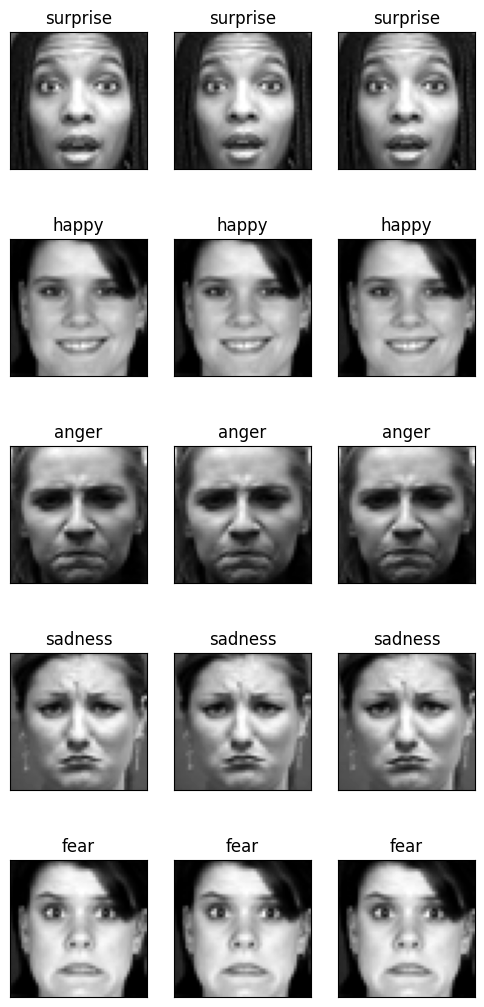

In [51]:
np.random.seed(42)
surprise_idx = np.random.choice(np.where(y_train[:, 0]==1)[0], size=1)
happy_idx = np.random.choice(np.where(y_train[:, 1]==1)[0], size=1)
anger_idx = np.random.choice(np.where(y_train[:, 2]==1)[0], size=1)
sad_idx = np.random.choice(np.where(y_train[:, 3]==1)[0], size=1)
fear_idx = np.random.choice(np.where(y_train[:, 4]==1)[0], size=1)

fig = pyplot.figure(1, (6,13))

i = 0
for name, idx in zip(label_emotion_mapper.values(), [surprise_idx, happy_idx, anger_idx, sad_idx, fear_idx]):
    for j in range(3):
        i += 1
        ax = pyplot.subplot(5,3,i)
        sample_img = X_train[idx][0,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name)

In [52]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [53]:

def build_dcnn(input_shape, show_arch=True):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=input_shape,
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.45, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.45, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.4, name='dropout_3'))

    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_7'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_8'
        )
    )
    net.add(BatchNormalization(name='batchnorm_8'))
    
    net.add(Dropout(0.4, name='dropout_4'))
    
    net.add(GlobalMaxPool2D(name="globalmax2d"))
    
    if show_arch:
        net.summary()
    
    return net


In [54]:

def memory_model(input_shape, num_class, show_arch=True):
    dcnn = build_dcnn(input_shape[1:], show_arch=False)
    
    model = Sequential(name="convolutional_Bidrectional_LSTM")

    model.add(
        TimeDistributed(
            dcnn,
            input_shape=input_shape,
            name="time_distributed",
        )
    )
    
    model.add(Bidirectional(LSTM(128, return_sequences=True, name="bidirect_lstm_1")))
    model.add(Dropout(.35, name="dropout_1"))
    model.add(Bidirectional(LSTM(64, return_sequences=False, name="bidirect_lstm_2")))
    model.add(Dropout(.45, name="dropout_2"))

    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Dropout(.7, name="dropout_3"))

    model.add(
        Dense(
            num_class,
            activation='softmax',
            name='out_layer'
        )
    )
    
    if show_arch:
        model.summary()
    
    return model


In [58]:
from keras.callbacks import ModelCheckpoint
checkpointer = [
    
    ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=7,
    min_lr=1e-7,
    verbose=1,
),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="final_model_weights.keras",
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        mode="max"
    )
]




batch_size = 32
epochs = 100

In [59]:
INPUT_SHAPE = (3, 48, 48, 1)
optim = optimizers.Nadam(0.001)

model = memory_model(INPUT_SHAPE, num_class=5)
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)


Model: "convolutional_Bidrectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 3, 512)            4691904   
 ributed)                                                        
                                                                 
 bidirectional_16 (Bidirect  (None, 3, 256)            656384    
 ional)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 3, 256)            0         
                                                                 
 bidirectional_17 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                   

In [60]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=checkpointer,
    use_multiprocessing=True
)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 3.4410 - accuracy: 0.1900
Epoch 1: val_accuracy improved from -inf to 0.18000, saving model to final_model_weights.keras
7/7 [==============================] - 30s 2s/step - loss: 3.4410 - accuracy: 0.1900 - val_loss: 1.6525 - val_accuracy: 0.1800 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 3.1748 - accuracy: 0.2200
Epoch 2: val_accuracy did not improve from 0.18000
7/7 [==============================] - 13s 2s/step - loss: 3.1748 - accuracy: 0.2200 - val_loss: 1.7314 - val_accuracy: 0.1800 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 2.9399 - accuracy: 0.2450
Epoch 3: val_accuracy did not improve from 0.18000
7/7 [==============================] - 14s 2s/step - loss: 2.9399 - accuracy: 0.2450 - val_loss: 1.7701 - val_accuracy: 0.1800 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 2.9355 - accuracy: 0.2200
Epoch 4: va

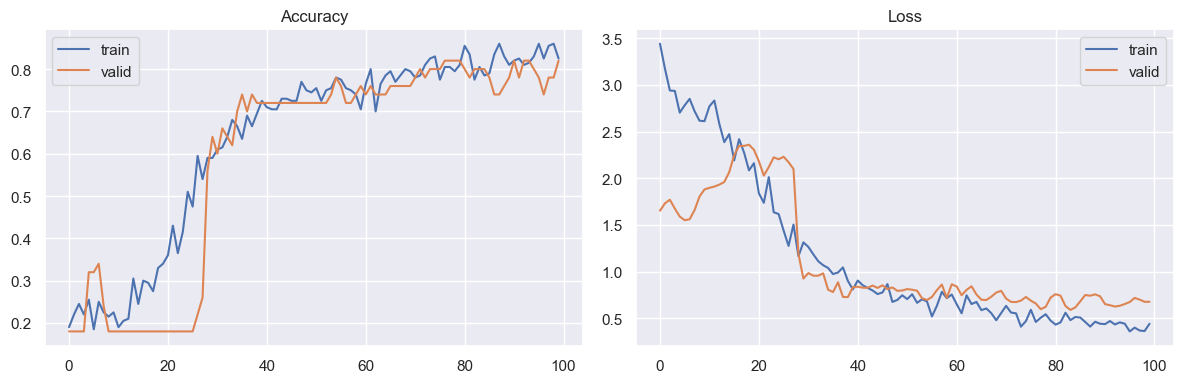

In [61]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.history['accuracy'], label='train')
sns.lineplot(history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.history['loss'], label='train')
sns.lineplot(history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

[0.11999999731779099, 0.2133333384990692, 0.2800000011920929, 0.2933333218097687, 0.2933333218097687, 0.2933333218097687, 0.2800000011920929, 0.30666667222976685, 0.3199999928474426, 0.1733333319425583, 0.1733333319425583, 0.1599999964237213, 0.1733333319425583, 0.1733333319425583, 0.1733333319425583, 0.1733333319425583, 0.1733333319425583, 0.1733333319425583, 0.1733333319425583, 0.1733333319425583, 0.1733333319425583, 0.1733333319425583, 0.1733333319425583, 0.1733333319425583, 0.1733333319425583, 0.18666666746139526, 0.20000000298023224, 0.3466666638851166, 0.4000000059604645, 0.3199999928474426, 0.6000000238418579, 0.5199999809265137, 0.54666668176651, 0.6800000071525574, 0.6399999856948853, 0.653333306312561, 0.6399999856948853, 0.7200000286102295, 0.7066666483879089, 0.6266666650772095, 0.7333333492279053, 0.6933333277702332, 0.7066666483879089, 0.6933333277702332, 0.7333333492279053, 0.6933333277702332, 0.6933333277702332, 0.7200000286102295, 0.7599999904632568, 0.7066666483879089

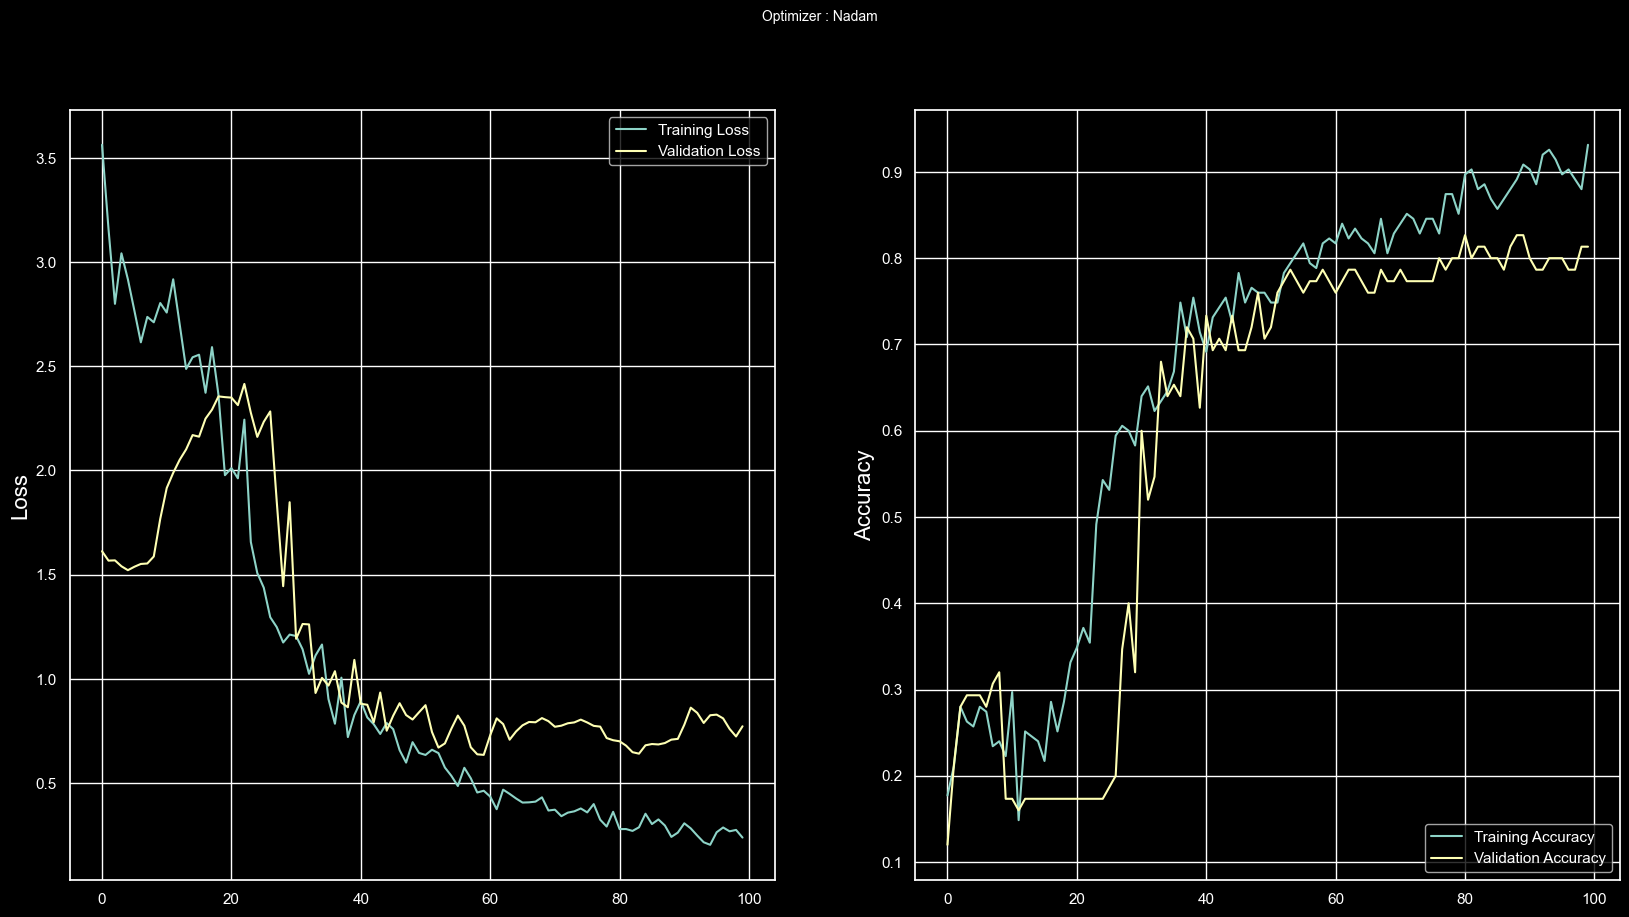

In [27]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Nadam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
print(history.history['val_accuracy'])
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

3/3 [==============================] - 1s 340ms/step
              precision    recall  f1-score   support

       happy       1.00      0.88      0.94        25
    surprise       0.88      1.00      0.93        21
       anger       0.60      0.92      0.73        13
     sadness       0.60      0.38      0.46         8
        fear       0.75      0.38      0.50         8

    accuracy                           0.81        75
   macro avg       0.77      0.71      0.71        75
weighted avg       0.83      0.81      0.80        75



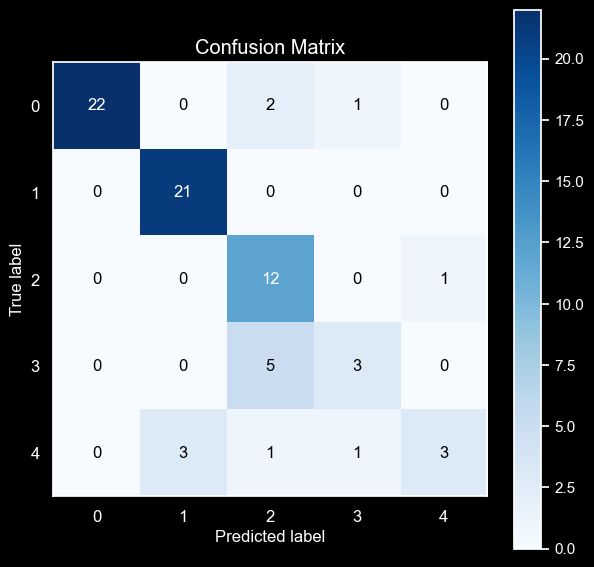

In [31]:
import numpy as np

# Assuming you have trained your model and loaded the validation data (X_valid, y_valid)

# Use the predict method to get class probabilities
yhat_valid_prob = model.predict(X_valid)

# Find the predicted classes using argmax
yhat_valid = np.argmax(yhat_valid_prob, axis=1)

# Now you can use scikitplot or other methods to visualize the confusion matrix
import scikitplot.metrics as skplt
import matplotlib.pyplot as plt

skplt.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7, 7))
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid, target_names=TOP_EMOTIONS))
plt.savefig("confusion_matrix.png")
